### Дипломная работа по курсу «Python для анализа данных»

- Рассчитайте основные статистики для переменных(среднее, медиана, мода, мин/макс, сред.отклонение)
- Рассчитайте и визуализируйте корреляционную матрицу для количественных переменных. Определите две самые скоррелированные и две наименее скоррелированные переменные
- Рассчитайте сколько сотрудников работает в каждом департаменте
- Покажите распределение сотрудников по зарплатам
- Покажите распределение сотрудников по зарплатам в каждом департаменте по отдельности
- Проверьте гипотезу, что сотрудники с высоким окладом проводят на работе больше времени, чем сотрудники с низким окладом
- Рассчитайте следующие показатели среди уволившихся и неуволившихся сотрудников (по отдельности):\
●Доля сотрудников с повышением за последние 5 лет\
●Средняя степень удовлетворенности\
●Среднее количество проектов
- Разделите данные на тестовую и обучающую выборкиПостроить модель LDA, предсказывающую уволился лисотрудник на основе имеющихся факторов (кроме department иsalary)Оценить качество модели на тестовой выборке



In [1]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
import statistics

In [2]:
data = pd.read_csv('HR.csv')
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [98]:
# проверим на заполненность:
data.shape

(14999, 11)

In [99]:
data = data.dropna()

In [100]:
data.shape

(14999, 11)

Нулевых значений в данных нет.

### 1. Основные статистики для количественных показателей

In [101]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,new_salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,0.594706
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,0.637183
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,1.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,2.000000


Найдем моду для каждого параметра

In [102]:
# "закомментировал" параметр average_montly_hours, чтобы не выдавало ошибку, далее покажу, почему:
print(f'satisfaction_level: {statistics.mode(data.satisfaction_level):.2f}')
print(f'last_evaluation: {statistics.mode(data.last_evaluation):.2f}')
print(f'number_project: {statistics.mode(data.number_project):.2f}')
#print(f'average_montly_hours: {statistics.mode(data.average_montly_hours):.2f}')
print(f'time_spend_company: {statistics.mode(data.time_spend_company):.2f}')
print(f'Work_accident: {statistics.mode(data.Work_accident):.2f}')
print(f'left: {statistics.mode(data.left):.2f}')
print(f'promotion_last_5years: {statistics.mode(data.promotion_last_5years):.2f}')

satisfaction_level: 0.10
last_evaluation: 0.55
number_project: 4.00
time_spend_company: 3.00
Work_accident: 0.00
left: 0.00
promotion_last_5years: 0.00


In [103]:
print(f'average_montly_hours: {statistics.mode(data.average_montly_hours):.2f}')

StatisticsError: ignored

Так, по параметру average_montly_hours чаще всего встречаются два значения...\
Посмотрим, какие:

---



In [105]:
data.average_montly_hours.value_counts().head()

156    153
135    153
149    148
151    147
160    136
Name: average_montly_hours, dtype: int64

Значения: 156 и 135 встречаются по 153 раза. Ок.

### 2. Рассчитаем и визуализируем корреляционную матрицу для количественных переменных.Определите две самые скоррелированные и две наименее скоррелированные переменные

In [106]:
# Оставляю в таблице только количественные переменные:
quantity_data = data[['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']]

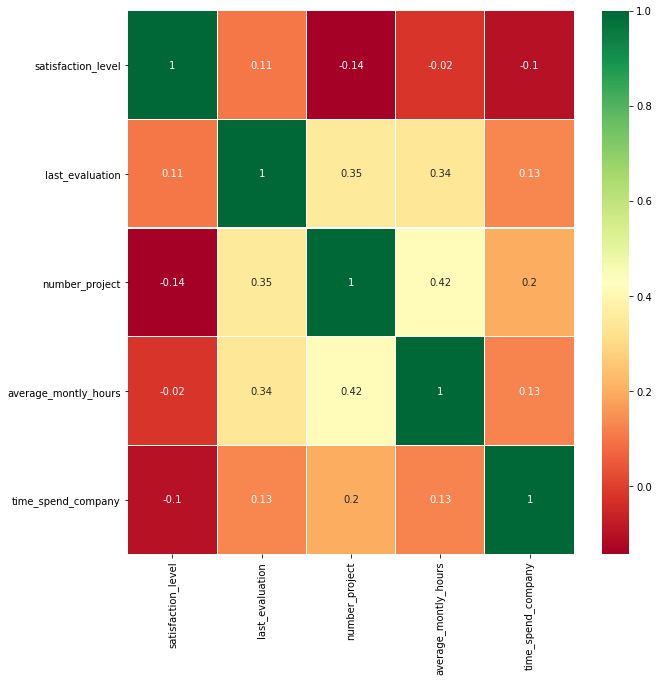

In [107]:
# Считаю и визуализимрую корреляцию между ними:
sns.heatmap(quantity_data.corr(),annot=True,cmap='RdYlGn',linewidths=0.1) #data.corr()-->матрица корреляций
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

Самые скоррелированные - среднее количество часов, проведенных на работе (average_montly_hours) и количество проектов (number_project).\
Самые нескоррелированные - количество проектов (number_project) и уровень удовлетворенности (satisfaction_level)

-- Но лично мне интересно, что на втором месте по отсутствию корреляции стоит пара:  уровень удовлетворенности (satisfaction_level) и стаж работы в компании (time_spend_company) - получается, что, чем дольше человек работает в компании, тем менее он удовлетворен работой. Тревожный знак.

### 3. Рассчитаем, сколько сотрудников работает в каждом департаменте

In [108]:
data.department.value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: department, dtype: int64

Продажи и обслуживание - технари, поддержка и IT - самые большие подразделения. Менеджмент - самое маленькое "подразделение", что логично.\
Смущает, что при  таком количестве IT спецов, что говорит о значительной компьютеризации компании, такое большое количество бухгалтеров (accounting) и специалистов по персоналу (hr) (на количество работников).\
Это может быть связано с тем, что профиль компании - розница всякой мелочи, типа канцтоваров, когда позиций очень много, или (и) расчет зарплаты сложен из-за хитрой системы оплаты труда и текучки. По службе персонала - да, скорее всего текучка имеет место - то есть розница мелкая и персонал в полях низкооплачиваемый и низкоквалифицированный, поэтому "текучий".\
Я бы подумал, что  речь идет о компании по рознице прессы, что-то вроде СоюзПечати (киоск, женщина и много мелочей вокруг). 

### 4. Показать распределение сотрудников по зарплатам

In [109]:
# Сначала "оцифруем" показатели уровня зарплат
data.loc[data.salary == 'low', 'new_salary'] = 0
data.loc[data.salary == 'medium', 'new_salary'] = 1
data.loc[data.salary == 'high', 'new_salary'] = 2

In [110]:
data.salary.value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

Итак, больше всех - сотрудников с низкими зарплатами (low), меньше всех - сотрудников с высокими зарплатами (high). Обычный расклад.\
Визуализируем:

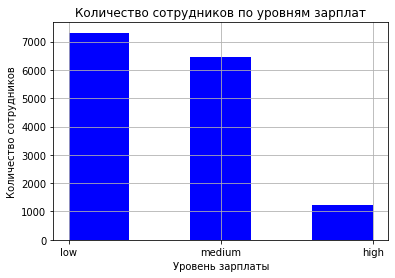

In [111]:
n, bins, patches = plt.hist(data['salary'], 5, facecolor='b')

plt.xlabel('Уровень зарплаты')
plt.ylabel('Количество сотрудников')
plt.title('Количество сотрудников по уровням зарплат')
plt.grid(True)
plt.show()

Так значительно нагляднее.

### 5. Покажем распределение сотрудников по зарплатам в каждом департаменте по отдельности

Покажем это на графике, опять же для наглядности:

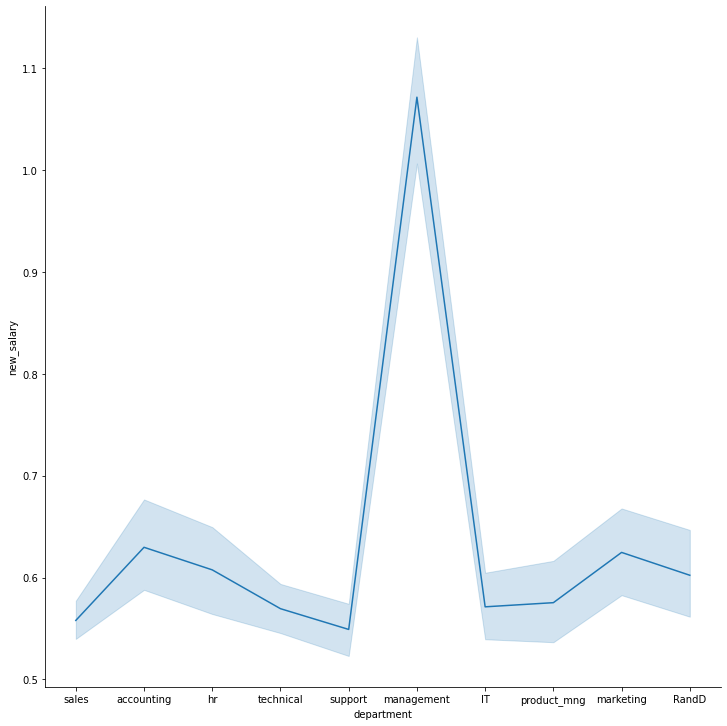

In [112]:
sns.relplot(x='department', 
            y='new_salary', 
            kind='line', 
            data=data,
            height = 10)

  Интересные результаты. Ну, очевидно, что самые высокие зарплаты у менеджмента. На мой взгляд, чересчур большая разница в уровне зарплат топов и остальных.\
  А вот высокий уровень зарплат в бухгалтерии (accounting) и маркетинге (marketing) - выше, чем в остальных подразделениях - может объясняться тем, что топы по этим направлениям - главный бухгалтер и директор по маркетингу отнесены не к "management", а к соответствующим подразделениям.\
  Если это не так, то имеем обычный перекос зарплат  - кто ближе к главе, тот больше получает.\
  С учетом того, что: 
  1. зарплаты продажников (sales) (люди на передовой!) и "поддержки" (уборщицы, дворники, ремонтники) - самые низкие в компании;
  2. зарплаты технарей (technical), продакт менеджеров (product_mng) и даже IT (IT) ниже зарплат кадровиков (hr), 
  могу предположить, что скоро дела у компании пойдут все хуже и хуже.  


### 6. Проверим гипотезу, что сотрудники с высоким окладом проводят на работе больше времени, чем сотрудники с низким окладом

Сколько сотрудников покинули компанию?

In [113]:
data.left.value_counts()

0    11428
1     3571
Name: left, dtype: int64

Гипотезы:

- Н0 = сотрудники с низким окладом проводят на работе больше времени
- Н1 = сотрудники с высоким окладом проводят на работе больше времениние

In [77]:

time_low_salary = data[data['new_salary']==0]['average_montly_hours']

time_high_salary = data[data['new_salary'] == 2]['average_montly_hours']


result = stats.ttest_ind(time_low_salary , time_high_salary , equal_var=False)

print(result)
if (result.pvalue < 0.05):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Ttest_indResult(statistic=0.7624331665385475, pvalue=0.4459045542257889)
Не отвергаем нулевую гипотезу



У нас нет оснований отвергнуть нулевую гипотезу. Величина оклада не оказывает существенного влияния на количество времени, проведенного сотрудником на работе.\
Проверим:

In [70]:
print(data[data['new_salary'] == 0]['average_montly_hours'].mean())
print(data[data['new_salary'] == 2]['average_montly_hours'].mean())

200.9965828321487
199.86742118027485


Получается, что в среднем сотрудники с низкой зарплатой проводят на аботе времени больше, чем высокооплачиваемые...

### 7. Рассчитаем следующие показатели среди уволившихся и не уволившихся сотрудников (по отдельности): 
●Доля сотрудников с повышением за последние 5 лет\
●Средняя степень удовлетворенности\
●Среднее количество проектов

Сколько сотрудников покинули компанию?

In [114]:
data.left.value_counts()

0    11428
1     3571
Name: left, dtype: int64

Работают - 11428\
Уволились - 3571

- Не уволившиеся:

In [115]:
# Оставим только не уволившихся:
data_left_0 = data.loc[data['left'] == 0]
#data_left_0.head()

In [116]:
# И посмотрим на основные статистические показатели по группе "не уволившиеся"
data_left_0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,new_salary
count,11428.000000,11428.000000,11428.000000,11428.000000,11428.000000,11428.000000,11428.0,11428.000000,11428.000000
mean,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.0,0.026251,0.650945
std,0.217104,0.162005,0.979884,45.682731,1.562348,0.379991,0.0,0.159889,0.655277
min,0.120000,0.360000,2.000000,96.000000,2.000000,0.000000,0.0,0.000000,0.000000
25%,0.540000,0.580000,3.000000,162.000000,2.000000,0.000000,0.0,0.000000,0.000000
50%,0.690000,0.710000,4.000000,198.000000,3.000000,0.000000,0.0,0.000000,1.000000
75%,0.840000,0.850000,4.000000,238.000000,4.000000,0.000000,0.0,0.000000,1.000000
max,1.000000,1.000000,6.000000,287.000000,10.000000,1.000000,0.0,1.000000,2.000000


Среди работающих ("не уволившиеся"):\
Средняя степень удовлетворенности (satisfaction_level): 0,67\
Среднее количество проектов (number_project): 3,79\
Доля сотрудников с повышением за последние 5 лет (promotion_last_5years): 2,62% - необходимо пояснить:
- поскольку в столбце "promotion_last_5years" только "0" или "1" ("1" - это "повышенный" сотрудник), соотношение числа повышенных (сумма этих "единиц") к общему количеству сотрудников есть как раз среднее арифметическое, то есть значение mean для этого столбца. Превратить его в проценты я смог в уме.

In [117]:
# Для интереса - количество повышенных среди работающих:
data_left_0['promotion_last_5years'].value_counts()
# 300 человек. Всего  - 11428. Процент повышенных - 300/11428 = 0,026251

0    11128
1      300
Name: promotion_last_5years, dtype: int64

- уволившиеся:

In [118]:
# Оставим только уволившихся:
data_left_1 = data.loc[data['left'] == 1]
#data_left_1.head()

In [119]:
# И посмотрим на показатели по группе "не уволившиеся"
data_left_1.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,new_salary
count,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.000000,3571.0,3571.000000,3571.000000
mean,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,1.0,0.005321,0.414730
std,0.263933,0.197673,1.818165,61.202825,0.977698,0.212364,0.0,0.072759,0.537341
min,0.090000,0.450000,2.000000,126.000000,2.000000,0.000000,1.0,0.000000,0.000000
25%,0.130000,0.520000,2.000000,146.000000,3.000000,0.000000,1.0,0.000000,0.000000
50%,0.410000,0.790000,4.000000,224.000000,4.000000,0.000000,1.0,0.000000,0.000000
75%,0.730000,0.900000,6.000000,262.000000,5.000000,0.000000,1.0,0.000000,1.000000
max,0.920000,1.000000,7.000000,310.000000,6.000000,1.000000,1.0,1.000000,2.000000


Среди уволившихся:\
Средняя степень удовлетворенности (satisfaction_level): 0,44\
Среднее количество проектов (number_project): 3,86\
Доля сотрудников с повышением за последние 5 лет (promotion_last_5years): 0,53% 


Вывод: Среди уволившихся по сравнению с не уволившимися: удовлетворенность в целом ниже, количество проектов в среднем - больше, а повышений вообще менее процента. Это логично.

### 8. Разделим данные на тестовую и обучающую выборки. Построим модель LDA, предсказывающую уволился ли сотрудник на основе имеющихся факторов (кроме department и salary). Оценим качество модели на тестовой выборке

In [136]:
# Подготовим таблицу для теста:
data_for_test = data[['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years']]

In [137]:
# Разделим данные на выборку для обучения и тестирования
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data_for_test, test_size=0.2)

In [138]:
len(data_train) # Значений в обучающей выборке

11999

In [139]:
len(data_test) # и в тестовой:

3000

In [140]:
y_train, y_test = data_train['left'], data_test['left']
del data_train['left']
del data_test['left']

In [141]:
# загрузим метод:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [142]:
lda = LinearDiscriminantAnalysis()

In [143]:
# обучение модели на тренировочных данных

lda.fit(data_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [144]:
# импортируем метод подсчета точности предсказанных данных в сравнении с фактическими

from sklearn.metrics import accuracy_score

In [147]:
# и оценим качество модели на тестовой выборке:
accuracy_score(y_test, lda.predict(data_test))

0.7566666666666667


Точность 76% - это соотношение верно предсказанных ответов к общему количеству ответов. Не очень большая точность.